## Importing data

In [4]:
import pandas as pd 
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from scipy.interpolate import make_interp_spline, BSpline

rr_data = pd.DataFrame(pd.read_csv("data/data_RR_merged_20190108.csv"))
m_data = pd.DataFrame(pd.read_csv("data/data_M_merged_20190108.csv"))

In [5]:
# get indices with warmup rounds
rr_indexNames = rr_data[rr_data['round'] == 'warmup'].index
# delete these row indexes from the frame
rr_data.drop(rr_indexNames, inplace=True)

# get indices with warmup rounds
m_indexNames = m_data[m_data['round'] == 'warmup'].index
# delete these row indexes from the frame
m_data.drop(m_indexNames, inplace=True)

In [6]:
# preview rr data
rr_data.head()

,ID,index_runner,side_runner,square_runner,python_tijd,spel,permutation,round,level,times_level_played_before,...,costheta,mabc_percentile_score,mabc_binary_score,gender,age_precise,ax_f,ay_f,az_f,acc,jerk
6267,101,23,2,5,1.497942e+09,RR,1,level_A,0,1,...,0.892647,37.0,0,1,7.009042,10.051521,0.465580,-0.175396,10.063826,0.486787
6268,101,23,2,5,1.497942e+09,RR,1,level_A,0,1,...,0.892970,37.0,0,1,7.009042,10.054876,0.492001,-0.189980,10.068699,0.426291
6269,101,23,2,5,1.497942e+09,RR,1,level_A,0,1,...,0.895913,37.0,0,1,7.009042,10.057725,0.516986,-0.204504,10.073080,0.366575
6270,101,23,2,5,1.497942e+09,RR,1,level_A,0,1,...,0.898400,37.0,0,1,7.009042,10.060076,0.540607,-0.218956,10.076970,0.205269
6271,101,23,2,5,1.497942e+09,RR,1,level_A,0,1,...,0.897208,37.0,0,1,7.009042,10.061938,0.562936,-0.233327,10.080374,0.166991


In [7]:
# preview m data
m_data.head()

,ID,index_runner,side_runner,square_runner,python_tijd,spel,round,level,times_level_played_before,incorrect,mabc_percentile_score,mabc_binary_score,gender,age_precise,ax_f,ay_f,az_f,acc,jerk
5959,101,4,0,4,1.497942e+09,M,level_A,0,1,0,37.0,0,1,7.009042,2.590391,-1.496124,-9.477220,9.938119,0.096884
5960,101,4,0,4,1.497942e+09,M,level_A,0,1,0,37.0,0,1,7.009042,2.562202,-1.482067,-9.485622,9.936721,0.086015
5961,101,4,0,4,1.497942e+09,M,level_A,0,1,0,37.0,0,1,7.009042,2.534205,-1.468358,-9.493919,9.935430,0.111047
5962,101,4,0,4,1.497942e+09,M,level_A,0,1,0,37.0,0,1,7.009042,2.506382,-1.455013,-9.502127,9.934255,0.091310
5963,101,4,0,4,1.497942e+09,M,level_A,0,1,0,37.0,0,1,7.009042,2.478715,-1.442047,-9.510264,9.933209,0.055894


In [8]:
# returns values of dictionary in a list
def dict_to_x_y(dictionary):
    x_list = []
    y_list = []
    for key in dictionary:
        x_list.append(dictionary[key][0])
        y_list.append(dictionary[key][1])
    return x_list, y_list

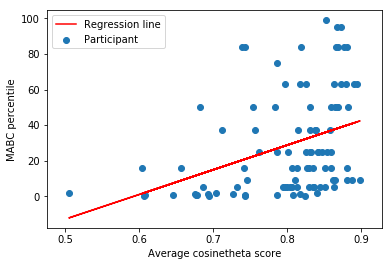

In [9]:
# ID is unique per child
# the higher the costheta score, the better the performance
# mabc_percentile_score is the label associated with the motor skills, again the higher the better

# create a dataframe containing this data
subdata = rr_data[['ID', 'costheta', 'mabc_percentile_score']]

# create a set of all unique children
children_ids = set(subdata['ID'])

# create a dictionary containing children id's as key and a tuple containing costheta and mabc_percentile as val
subdata_dictionary = {}
for child_id in children_ids:
    avg_ct = subdata.loc[subdata['ID'] == child_id]['costheta'].mean()
    mabc_perc = subdata.loc[subdata['ID'] == child_id]['mabc_percentile_score'].mean()
    subdata_dictionary[child_id] = (avg_ct, mabc_perc)
#     print("Child: {} has an avarage costheta score of {} and an MABC percentile equal to {}.".format(child_id, round(avg_ct, 5), round(mabc_perc, 3)))

avg_ct, mabc = dict_to_x_y(subdata_dictionary)
slope, intercept, r_value, p_value, std_err = stats.linregress(avg_ct, mabc)
avg_ct_slope = [i * slope for i in avg_ct]

# scatter plot with mabc
plt.scatter(avg_ct, mabc, label='Participant')
plt.plot(avg_ct, intercept + avg_ct_slope, 'r', label='Regression line')
plt.xlabel("Average cosinetheta score")
plt.ylabel("MABC percentile")
plt.legend()


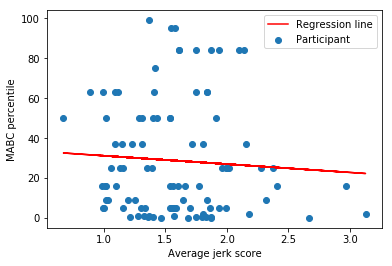

In [10]:
# ID is unique per child
# the higher the costheta score, the better the performance
# mabc_percentile_score is the label associated with the motor skills, again the higher the better

# create a dataframe containing this data
subdata_jerk = rr_data[['ID', 'jerk', 'mabc_percentile_score']]

# create a dictionary containing children id's as key and a tuple containing costheta and mabc_percentile as val
subdata_jerk_dictionary = {}
for child_id in children_ids:
    avg_jerk = subdata_jerk.loc[subdata['ID'] == child_id]['jerk'].mean()
    mabc_perc = subdata_jerk.loc[subdata['ID'] == child_id]['mabc_percentile_score'].mean()
    subdata_jerk_dictionary[child_id] = (avg_jerk, mabc_perc)
#     print("Child: {} has an avarage costheta score of {} and an MABC percentile equal to {}.".format(child_id, round(avg_ct, 5), round(mabc_perc, 3)))

avg_jerk, mabc = dict_to_x_y(subdata_jerk_dictionary)
slope, intercept, r_value, p_value, std_err = stats.linregress(avg_jerk, mabc)
avg_jerk_slope = [i * slope for i in avg_jerk]

# scatter plot with mabc
plt.scatter(avg_jerk, mabc, label='Participant')
plt.plot(avg_jerk, intercept + avg_jerk_slope, 'r', label='Regression line')
plt.xlabel("Average jerk score")
plt.ylabel("MABC percentile")
plt.legend()


In [11]:
rr_data_time = rr_data

times = []
for child_id in children_ids:
    child_frame = rr_data.loc[subdata['ID'] == child_id]
    mintime = child_frame['python_tijd'].min()
    fixedtime = child_frame['python_tijd'] - mintime
    times.append(fixedtime.values)
    
    
realtimes = [item for sublist in times for item in sublist]

rr_data_time.insert(4, 'real_time', realtimes)


In [12]:
rr_data_time.head()

,ID,index_runner,side_runner,square_runner,real_time,python_tijd,spel,permutation,round,level,...,costheta,mabc_percentile_score,mabc_binary_score,gender,age_precise,ax_f,ay_f,az_f,acc,jerk
6267,101,23,2,5,0.00,1.497942e+09,RR,1,level_A,0,...,0.892647,37.0,0,1,7.009042,10.051521,0.465580,-0.175396,10.063826,0.486787
6268,101,23,2,5,0.01,1.497942e+09,RR,1,level_A,0,...,0.892970,37.0,0,1,7.009042,10.054876,0.492001,-0.189980,10.068699,0.426291
6269,101,23,2,5,0.02,1.497942e+09,RR,1,level_A,0,...,0.895913,37.0,0,1,7.009042,10.057725,0.516986,-0.204504,10.073080,0.366575
6270,101,23,2,5,0.02,1.497942e+09,RR,1,level_A,0,...,0.898400,37.0,0,1,7.009042,10.060076,0.540607,-0.218956,10.076970,0.205269
6271,101,23,2,5,0.03,1.497942e+09,RR,1,level_A,0,...,0.897208,37.0,0,1,7.009042,10.061938,0.562936,-0.233327,10.080374,0.166991


[(0.1, 102), (0.1, 116), (0.1, 254), (0.1, 316), (0.5, 110), (0.5, 130), (0.5, 133), (0.5, 207), (0.5, 314), (0.5, 348), (0.5, 350), (1.0, 109), (1.0, 120), (1.0, 235), (1.0, 347), (2.0, 103), (2.0, 328), (2.0, 337), (5.0, 105), (5.0, 119), (5.0, 196), (5.0, 205), (5.0, 221), (5.0, 229), (5.0, 309), (5.0, 312), (5.0, 339), (5.0, 342), (5.0, 344), (5.0, 352), (5.0, 353), (5.0, 357), (9.0, 118), (9.0, 131), (9.0, 199), (9.0, 220), (9.0, 237), (9.0, 255), (9.0, 318), (16.0, 121), (16.0, 135), (16.0, 192), (16.0, 193), (16.0, 201), (16.0, 222), (16.0, 223), (16.0, 234), (16.0, 304), (16.0, 326), (16.0, 343), (25.0, 134), (25.0, 195), (25.0, 200), (25.0, 230), (25.0, 302), (25.0, 317), (25.0, 332), (25.0, 340), (25.0, 351), (25.0, 354), (25.0, 355), (37.0, 101), (37.0, 113), (37.0, 136), (37.0, 226), (37.0, 236), (37.0, 307), (37.0, 333), (50.0, 132), (50.0, 190), (50.0, 203), (50.0, 231), (50.0, 322), (50.0, 330), (50.0, 338), (50.0, 346), (50.0, 356), (63.0, 104), (63.0, 115), (63.0, 191)

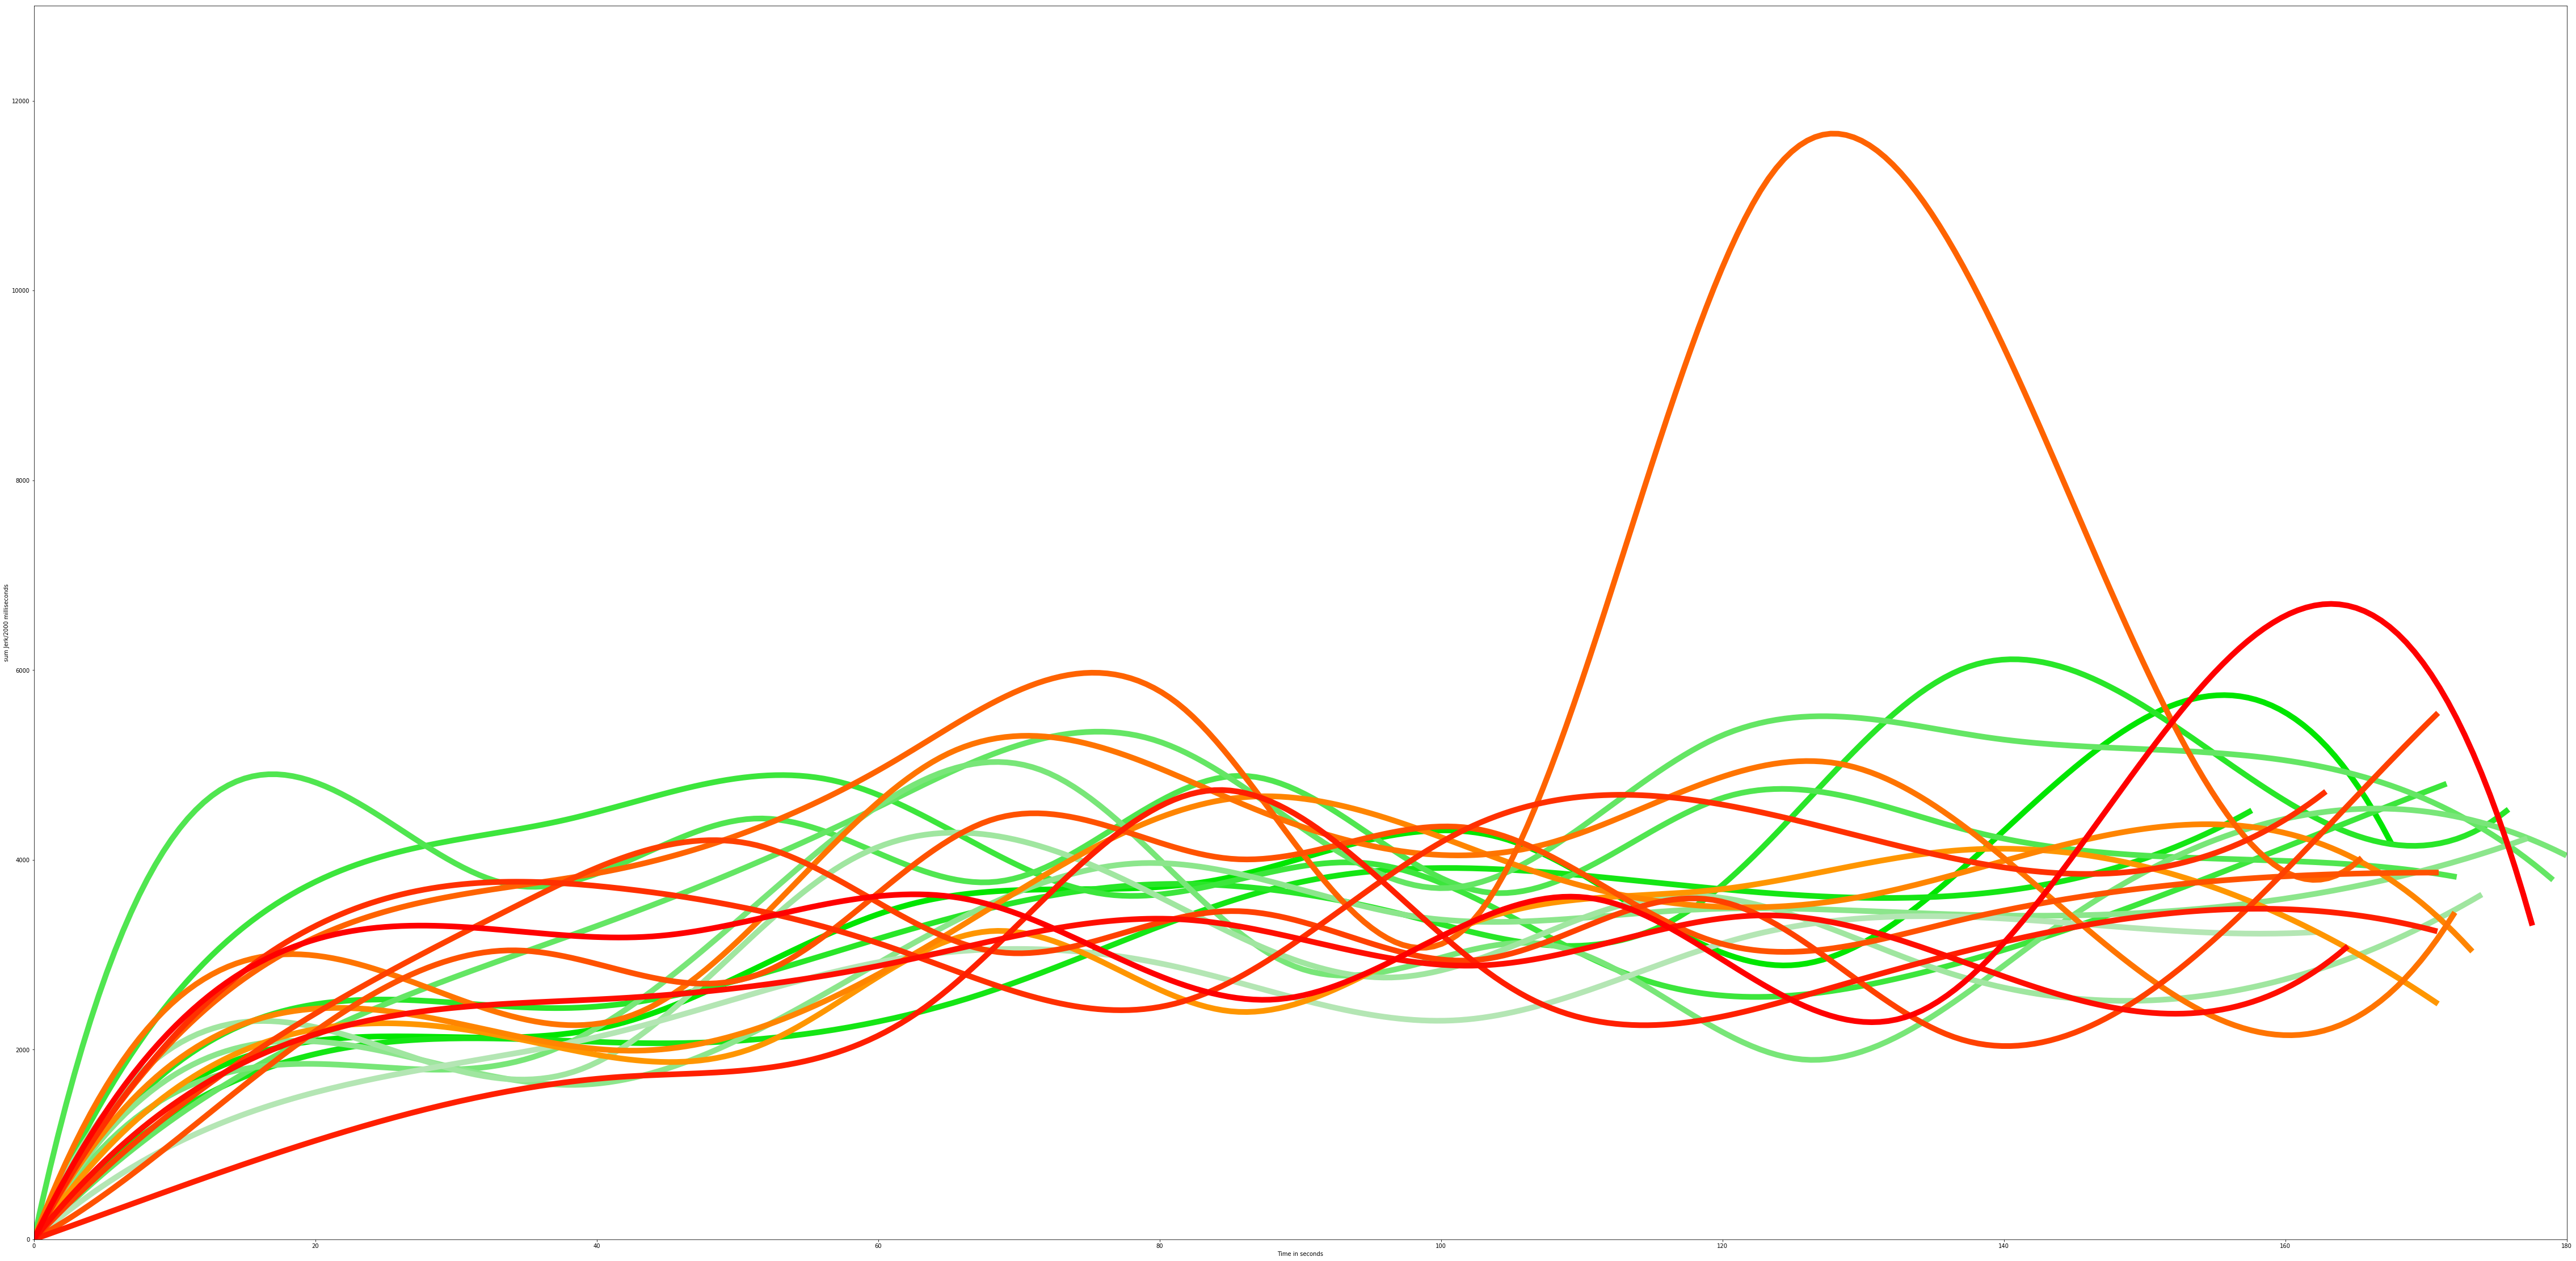

In [13]:
from scipy.interpolate import make_interp_spline, BSpline
fig, plots = plt.subplots(figsize=(80,40), sharex=True, sharey=True)

plt.xlim(0, 180)
plt.ylim(0, 13000)

plots.set_xlabel('Time in seconds')
plots.set_ylabel('sum Jerk/2000 milliseconds')

font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 100}

plt.rc('font', **font)

IDlist = list(set(rr_data_time.loc[rr_data_time['ID'] >= 101]['ID'].values))
Jerklist = [np.mean(rr_data.loc[rr_data['ID'] == ID]['jerk'].values) for ID in IDlist]

MABClist = [list(rr_data.loc[rr_data['ID'] == ID]['mabc_percentile_score'])[-1] for ID in IDlist]
MABCID = [x for _,x in sorted(zip(MABClist,IDlist))]

JerkID = [x for _,x in sorted(zip(Jerklist,IDlist))]
color = 0


for ID in MABCID[-10:]:
    tijd = [x for x in rr_data.loc[rr_data['ID'] == ID]['real_time'].values]
    jerking = [x for x in rr_data.loc[rr_data['ID'] == ID]['jerk'].values]
    
    asx, asy = [0], [0]
    count = 2000
    sumjerk = 0
    for i in range(len(tijd)):
        sumjerk += jerking[i]
        count -= 1
        if count == 0:
            asx.append(tijd[i])
            asy.append(sumjerk)
            count = 2000
            sumjerk = 0
    
    xnew = np.linspace(min(asx), max(asx), 300)
    spl = make_interp_spline(asx, asy, k=3)
    smoothy = spl(xnew)
    
    colors = []
    for i in range(1):
        colors.append("#%02x%02x%02x" % (int(max(min(color*2, 255), 0)), int(max(min(230, 255), 0)), int(color*2)))
    
    plots.plot(xnew, smoothy, linewidth=10, color=colors[0])
    color += 10

color = 0
for ID in MABCID[:10]:
    tijd = [x for x in rr_data.loc[rr_data['ID'] == ID]['real_time'].values]
    jerking = [x for x in rr_data.loc[rr_data['ID'] == ID]['jerk'].values]
    
    asx, asy = [0], [0]
    count = 2000
    sumjerk = 0
    for i in range(len(tijd)):
        sumjerk += jerking[i]
        count -= 1
        if count == 0:
            asx.append(tijd[i])
            asy.append(sumjerk)
            count = 2000
            sumjerk = 0
    
    xnew = np.linspace(min(asx), max(asx), 300)
    spl = make_interp_spline(asx, asy, k=3)
    smoothy = spl(xnew)
    
    colors = []
    for i in range(1):
        colors.append("#%02x%02x%02x" % (int(max(min(255, 255), 0)), int(max(min(150-color*1.7, 255), 0)), 0))
    
    plots.plot(xnew, smoothy, linewidth=10, color=colors[0])
    color += 10
    
print(sorted(zip(MABClist,IDlist)))


In [14]:
print(list(set(rr_data_time.loc[rr_data_time['ID'] >= 101]['ID'].values)))
IDlist = list(set(rr_data_time.loc[rr_data_time['ID'] >= 101]['ID'].values))
Jerklist = [np.mean(rr_data.loc[rr_data['ID'] == ID]['jerk'].values) for ID in IDlist]

print([x for _,x in sorted(zip(Jerklist,IDlist))])

[101, 102, 103, 104, 105, 107, 109, 110, 111, 113, 115, 116, 118, 119, 120, 121, 130, 131, 132, 133, 134, 135, 136, 190, 191, 192, 193, 195, 196, 197, 199, 200, 201, 203, 205, 207, 208, 220, 221, 222, 223, 225, 226, 229, 230, 231, 233, 234, 235, 236, 237, 251, 254, 255, 302, 304, 307, 309, 312, 314, 316, 317, 318, 319, 322, 324, 326, 327, 328, 329, 330, 332, 333, 334, 336, 337, 338, 339, 340, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358]
[203, 191, 326, 104, 229, 309, 234, 304, 131, 231, 118, 134, 101, 225, 343, 251, 340, 236, 196, 230, 255, 350, 113, 237, 120, 190, 105, 333, 338, 109, 342, 351, 207, 349, 235, 354, 132, 314, 324, 111, 356, 102, 121, 339, 346, 330, 352, 358, 119, 223, 347, 221, 327, 357, 135, 345, 197, 220, 222, 116, 344, 307, 348, 115, 107, 201, 130, 328, 226, 110, 318, 233, 334, 312, 208, 254, 133, 322, 319, 205, 302, 332, 353, 195, 355, 329, 336, 136, 337, 200, 199, 317, 193, 316, 192, 103]


/usr/lib/python3/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


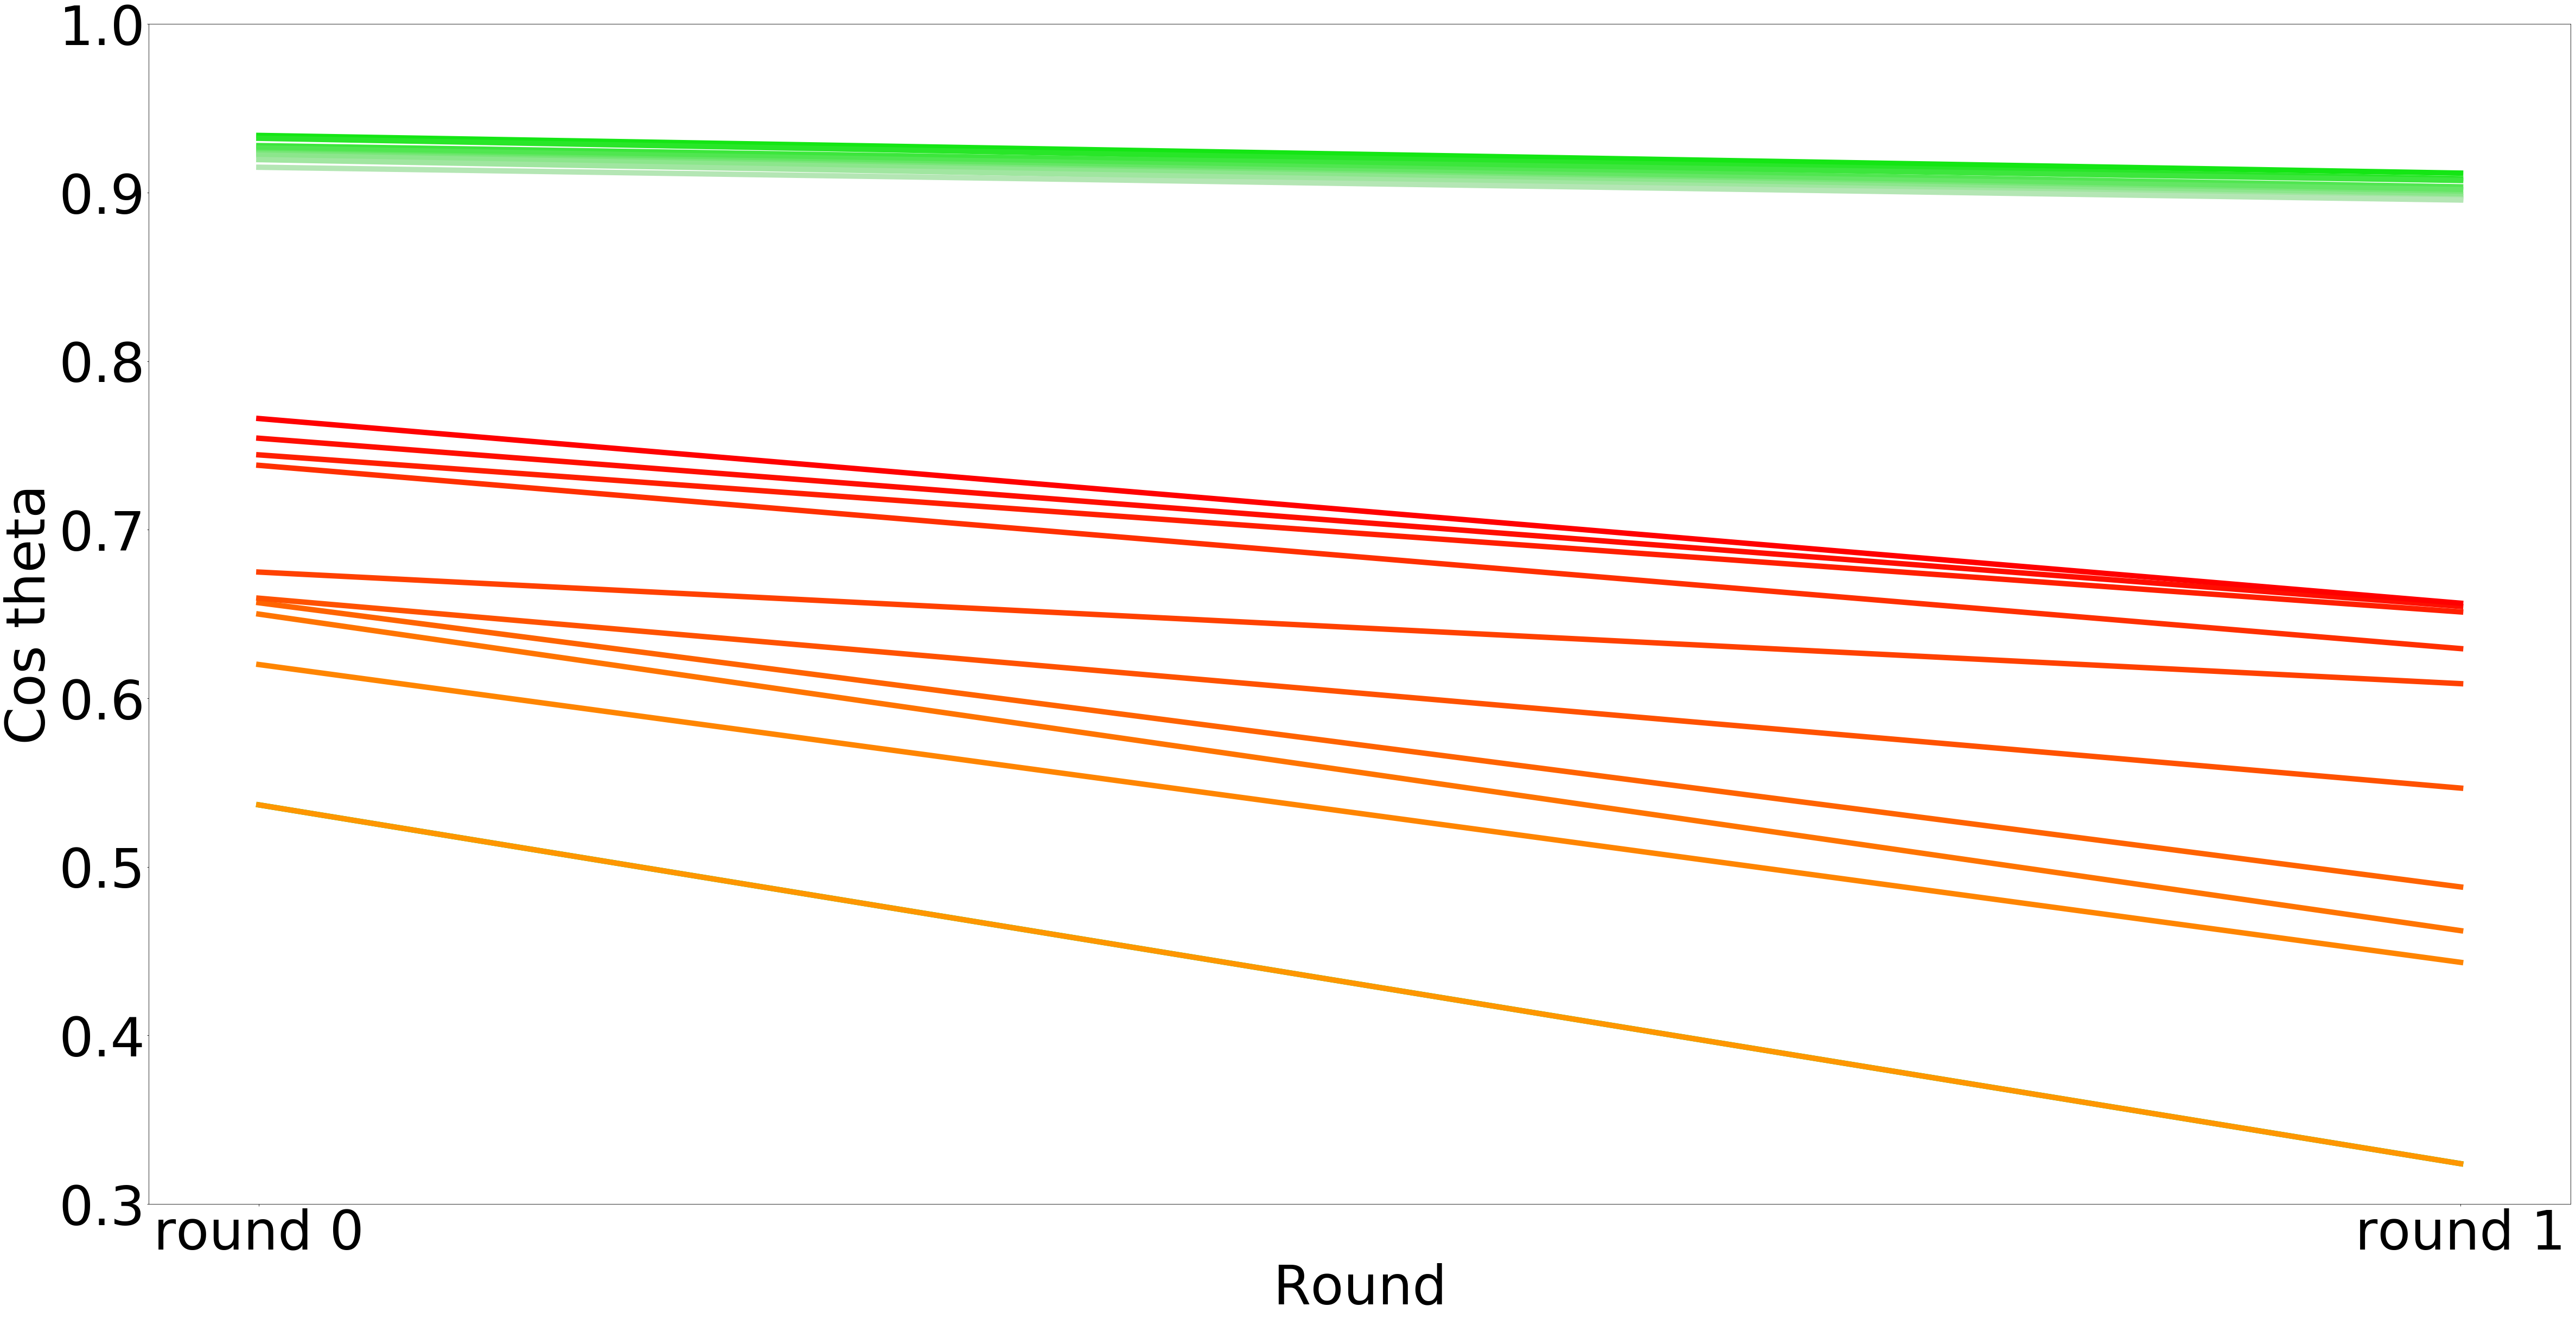

In [15]:
figcos, plotcos = plt.subplots(figsize=(80,40), sharex=True, sharey=True)

plt.xlim(-0.05, 1.05)
plt.ylim(0.3, 1)

plotcos.set_xlabel('Round')
plotcos.set_ylabel('Cos theta')

font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 100}

plt.rc('font', **font)

IDlist = list(set(rr_data_time.loc[rr_data_time['ID'] >= 101]['ID'].values))

CosAlist, CosBlist, CosClist, CosDlist, CosElist, CosFlist = [],[],[],[],[],[]

for ID in IDlist:
    listcos = rr_data.loc[rr_data['ID'] == ID, ['costheta', 'round']]
    CosAlist.append(np.mean(listcos.loc[listcos['round'] == 'level_A']['costheta']))
    CosBlist.append(np.mean(listcos.loc[listcos['round'] == 'level_B']['costheta']))
    CosClist.append(np.mean(listcos.loc[listcos['round'] == 'level_C']['costheta']))
    CosDlist.append(np.mean(listcos.loc[listcos['round'] == 'level_D']['costheta']))
    CosElist.append(np.mean(listcos.loc[listcos['round'] == 'level_E']['costheta']))
    CosFlist.append(np.mean(listcos.loc[listcos['round'] == 'level_F']['costheta']))

CosAID = [x for x,_ in sorted(zip(CosAlist,IDlist))]
CosFID = [x for x,_ in sorted(zip(CosFlist,IDlist))]

color = 0


for i in range(len(CosAID[:10])):
    asx, asy = ['round 0', 'round 1'], [CosAID[-i], CosFID[-i]]
    
    colors = []
    for i in range(1):
        colors.append("#%02x%02x%02x" % (int(max(min(color*2, 255), 0)), int(max(min(230, 255), 0)), int(color*2)))
    
    plotcos.plot(asx, asy, linewidth=10, color=colors[0])
    color += 10

color = 0
for i in range(len(CosAID[:10])):
    asx, asy = ['round 0', 'round 1'], [CosAID[i], CosFID[i]]
    
    colors = []
    for i in range(1):
        colors.append("#%02x%02x%02x" % (int(max(min(255, 255), 0)), int(max(min(150-color*1.7, 255), 0)), 0))
    
    plotcos.plot(asx, asy, linewidth=10, color=colors[0])
    plotcos.scatter(asx, asy, color=colors[0])
    color += 10
    


In [16]:
shit = [list(rr_data.loc[rr_data['ID'] == ID]['mabc_percentile_score'])[-1] for ID in IDlist]
print(shit)

# print(sorted(zip([rr_data.loc[rr_data['ID'] == ID]['mabc_percentile_score'] for ID in IDlist],IDlist)))

# print([sum(rr_data.loc[rr_data['round'] == 'level_A']['costheta']) for ID in IDlist])

[37.0, 0.1, 2.0, 63.0, 5.0, 84.0, 1.0, 0.5, 75.0, 37.0, 63.0, 0.1, 9.0, 5.0, 1.0, 16.0, 0.5, 9.0, 50.0, 0.5, 25.0, 16.0, 37.0, 50.0, 63.0, 16.0, 16.0, 25.0, 5.0, 84.0, 9.0, 25.0, 16.0, 50.0, 5.0, 0.5, 84.0, 9.0, 5.0, 16.0, 16.0, 63.0, 37.0, 5.0, 25.0, 50.0, 63.0, 16.0, 1.0, 37.0, 9.0, 63.0, 0.1, 9.0, 25.0, 16.0, 37.0, 5.0, 5.0, 0.5, 0.1, 25.0, 9.0, 84.0, 50.0, 63.0, 16.0, 95.0, 2.0, 84.0, 50.0, 25.0, 37.0, 63.0, 84.0, 2.0, 50.0, 5.0, 25.0, 5.0, 16.0, 5.0, 84.0, 50.0, 1.0, 0.5, 99.0, 0.5, 25.0, 5.0, 5.0, 25.0, 25.0, 50.0, 5.0, 95.0]


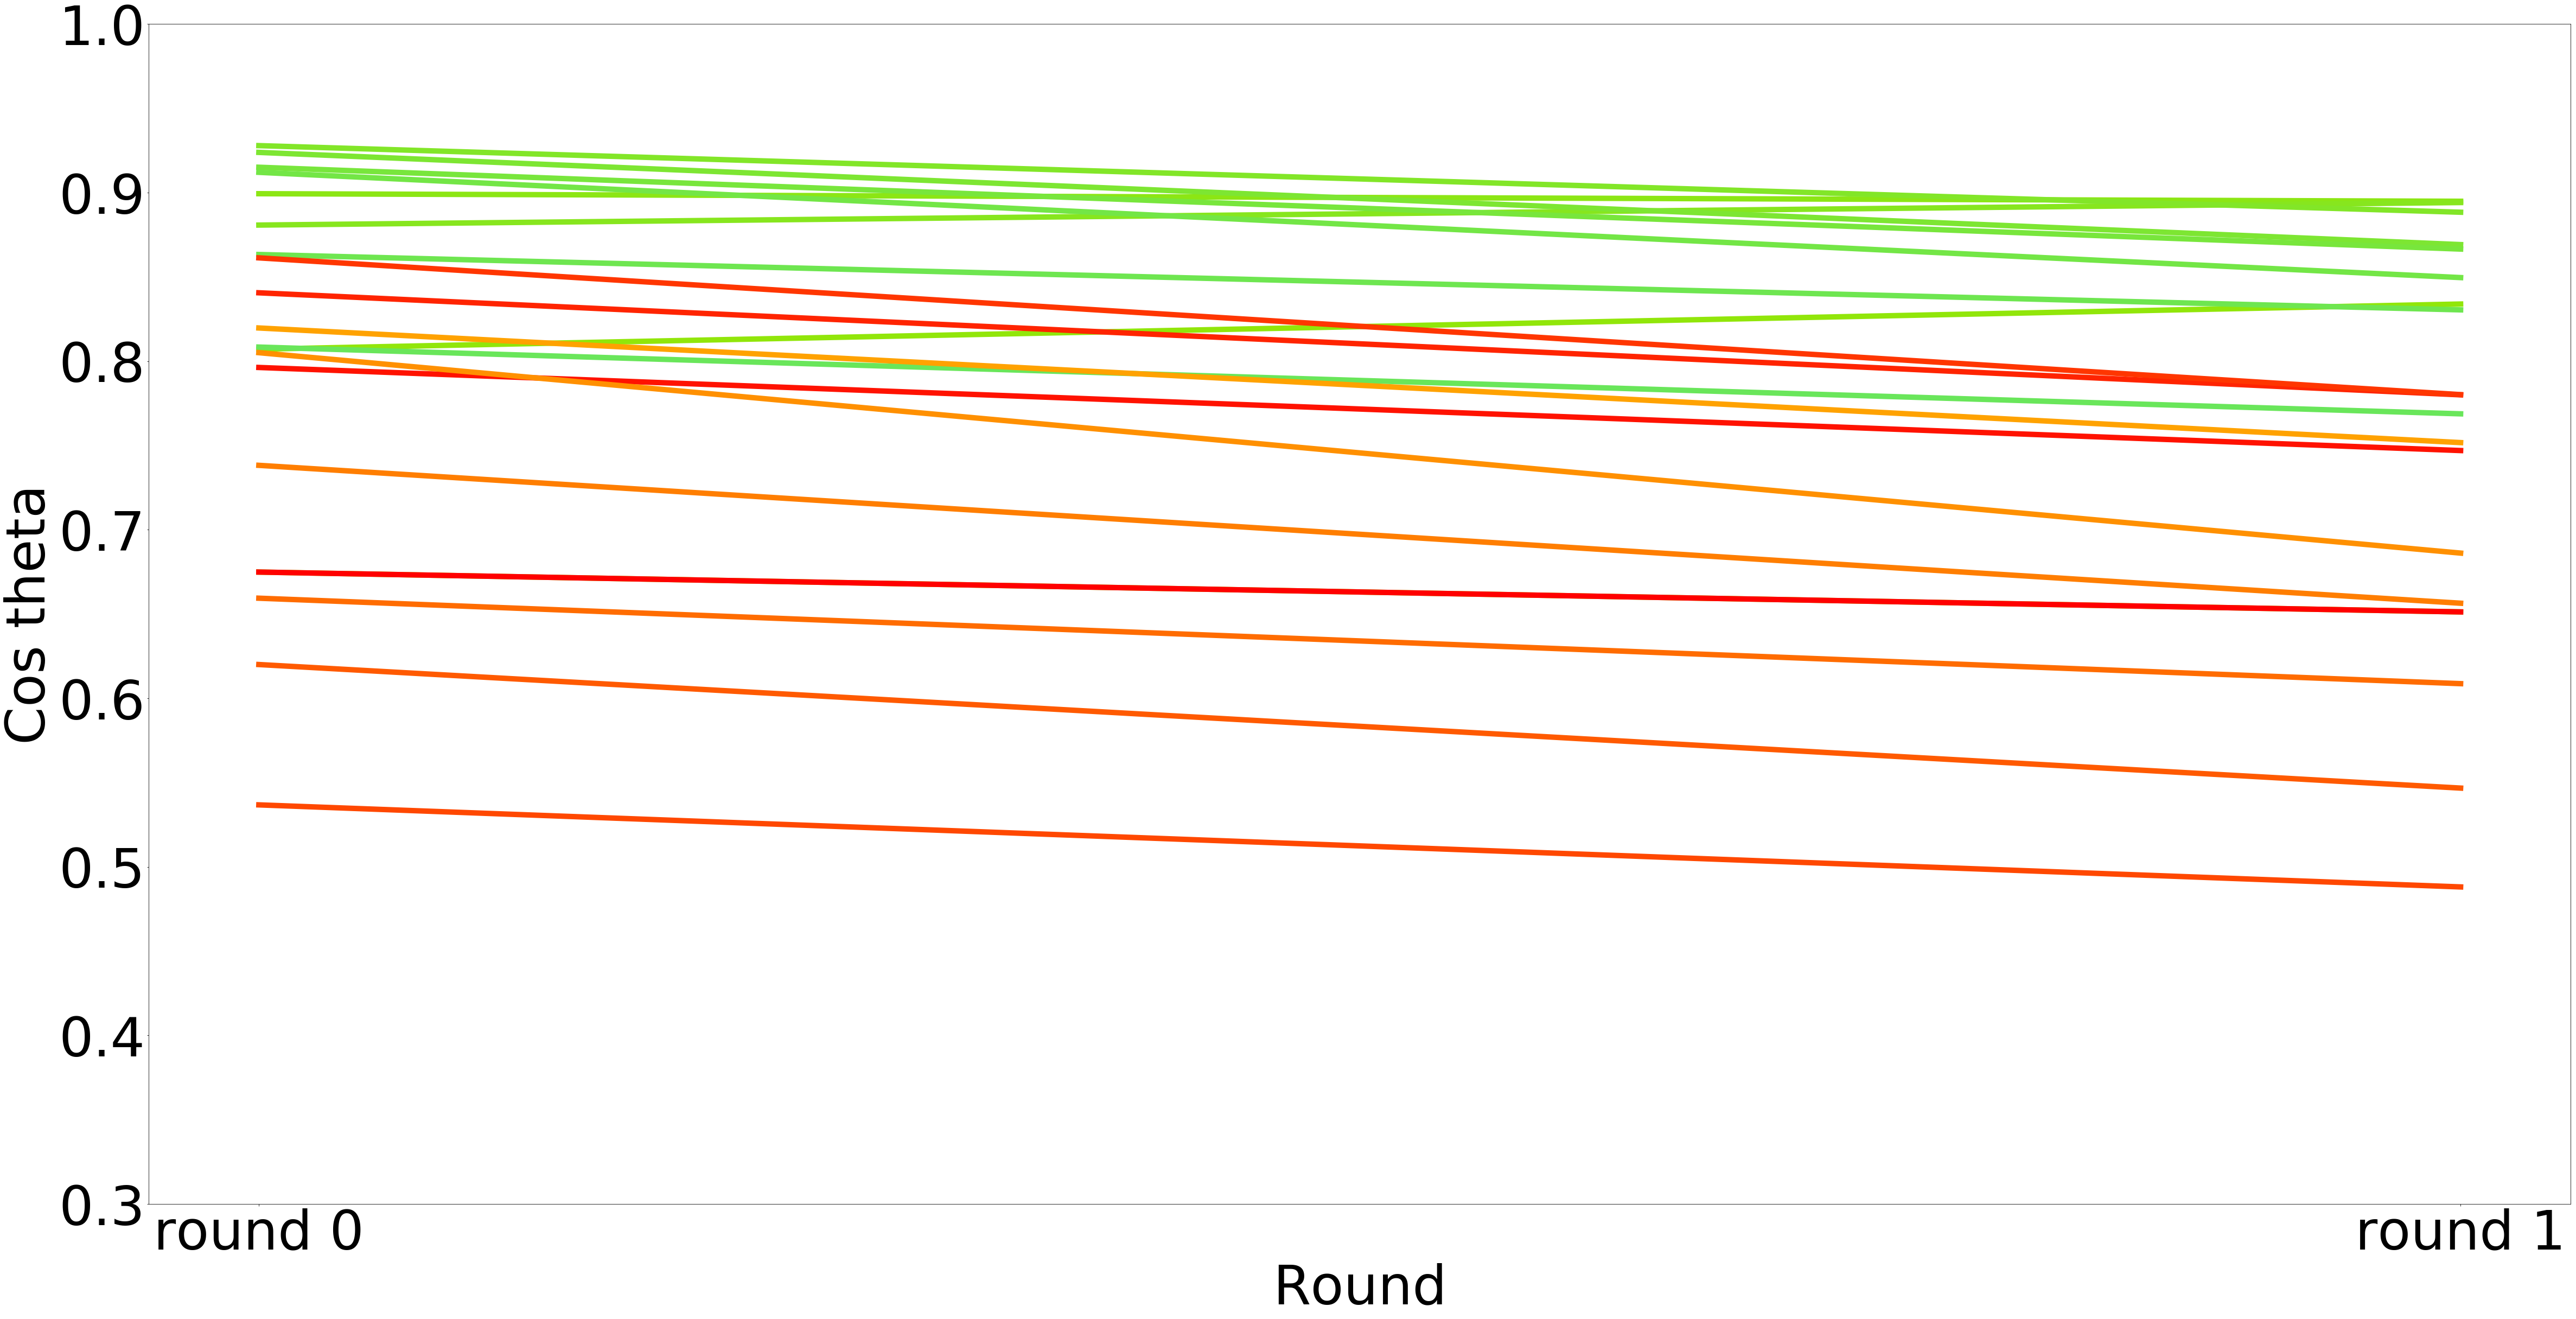

In [17]:
figcos, plotcos = plt.subplots(figsize=(80,40), sharex=True, sharey=True)

plt.xlim(-0.05, 1.05)
plt.ylim(0.3, 1)

plotcos.set_xlabel('Round')
plotcos.set_ylabel('Cos theta')

font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 100}

plt.rc('font', **font)

IDlist = list(set(rr_data_time.loc[rr_data_time['ID'] >= 101]['ID'].values))

CosAlist, CosBlist, CosClist, CosDlist, CosElist, CosFlist = [],[],[],[],[],[]

for ID in IDlist:
    listcos = rr_data.loc[rr_data['ID'] == ID, ['costheta', 'round']]
    CosAlist.append(np.mean(listcos.loc[listcos['round'] == 'level_A']['costheta']))
    CosBlist.append(np.mean(listcos.loc[listcos['round'] == 'level_B']['costheta']))
    CosClist.append(np.mean(listcos.loc[listcos['round'] == 'level_C']['costheta']))
    CosDlist.append(np.mean(listcos.loc[listcos['round'] == 'level_D']['costheta']))
    CosElist.append(np.mean(listcos.loc[listcos['round'] == 'level_E']['costheta']))
    CosFlist.append(np.mean(listcos.loc[listcos['round'] == 'level_F']['costheta']))

CosAMABC = [x for _,x in sorted(zip(MABClist,CosAlist))]
CosBMABC = [x for _,x in sorted(zip(MABClist,CosBlist))]
CosCMABC = [x for _,x in sorted(zip(MABClist,CosClist))]
CosDMABC = [x for _,x in sorted(zip(MABClist,CosDlist))]
CosEMABC = [x for _,x in sorted(zip(MABClist,CosElist))]
CosFMABC = [x for _,x in sorted(zip(MABClist,CosFlist))]

color = 0


for i in range(len(MABCID[:10])):
    asx, asy = ['round 0', 'round 1'], [CosAMABC[-i], CosFMABC[-i]]
    
    colors = []
    for i in range(1):
        colors.append("#%02x%02x%02x" % (int(max(min(150-color*0.5, 255), 0)), int(max(min(230, 255), 0)), int(color)))
    
    plotcos.plot(asx, asy, linewidth=10, color=colors[0])
    color += 10

color = 0
for i in range(len(MABCID[:10])):
    asx, asy = ['round 0', 'round 1'], [CosAMABC[i], CosFMABC[i]]
    
    colors = []
    for i in range(1):
        colors.append("#%02x%02x%02x" % (int(max(min(255, 255), 0)), int(max(min(color*1.8, 255), 0)), 0))
    
    plotcos.plot(asx, asy, linewidth=10, color=colors[0])
    plotcos.scatter(asx, asy, color=colors[0])
    color += 10
    


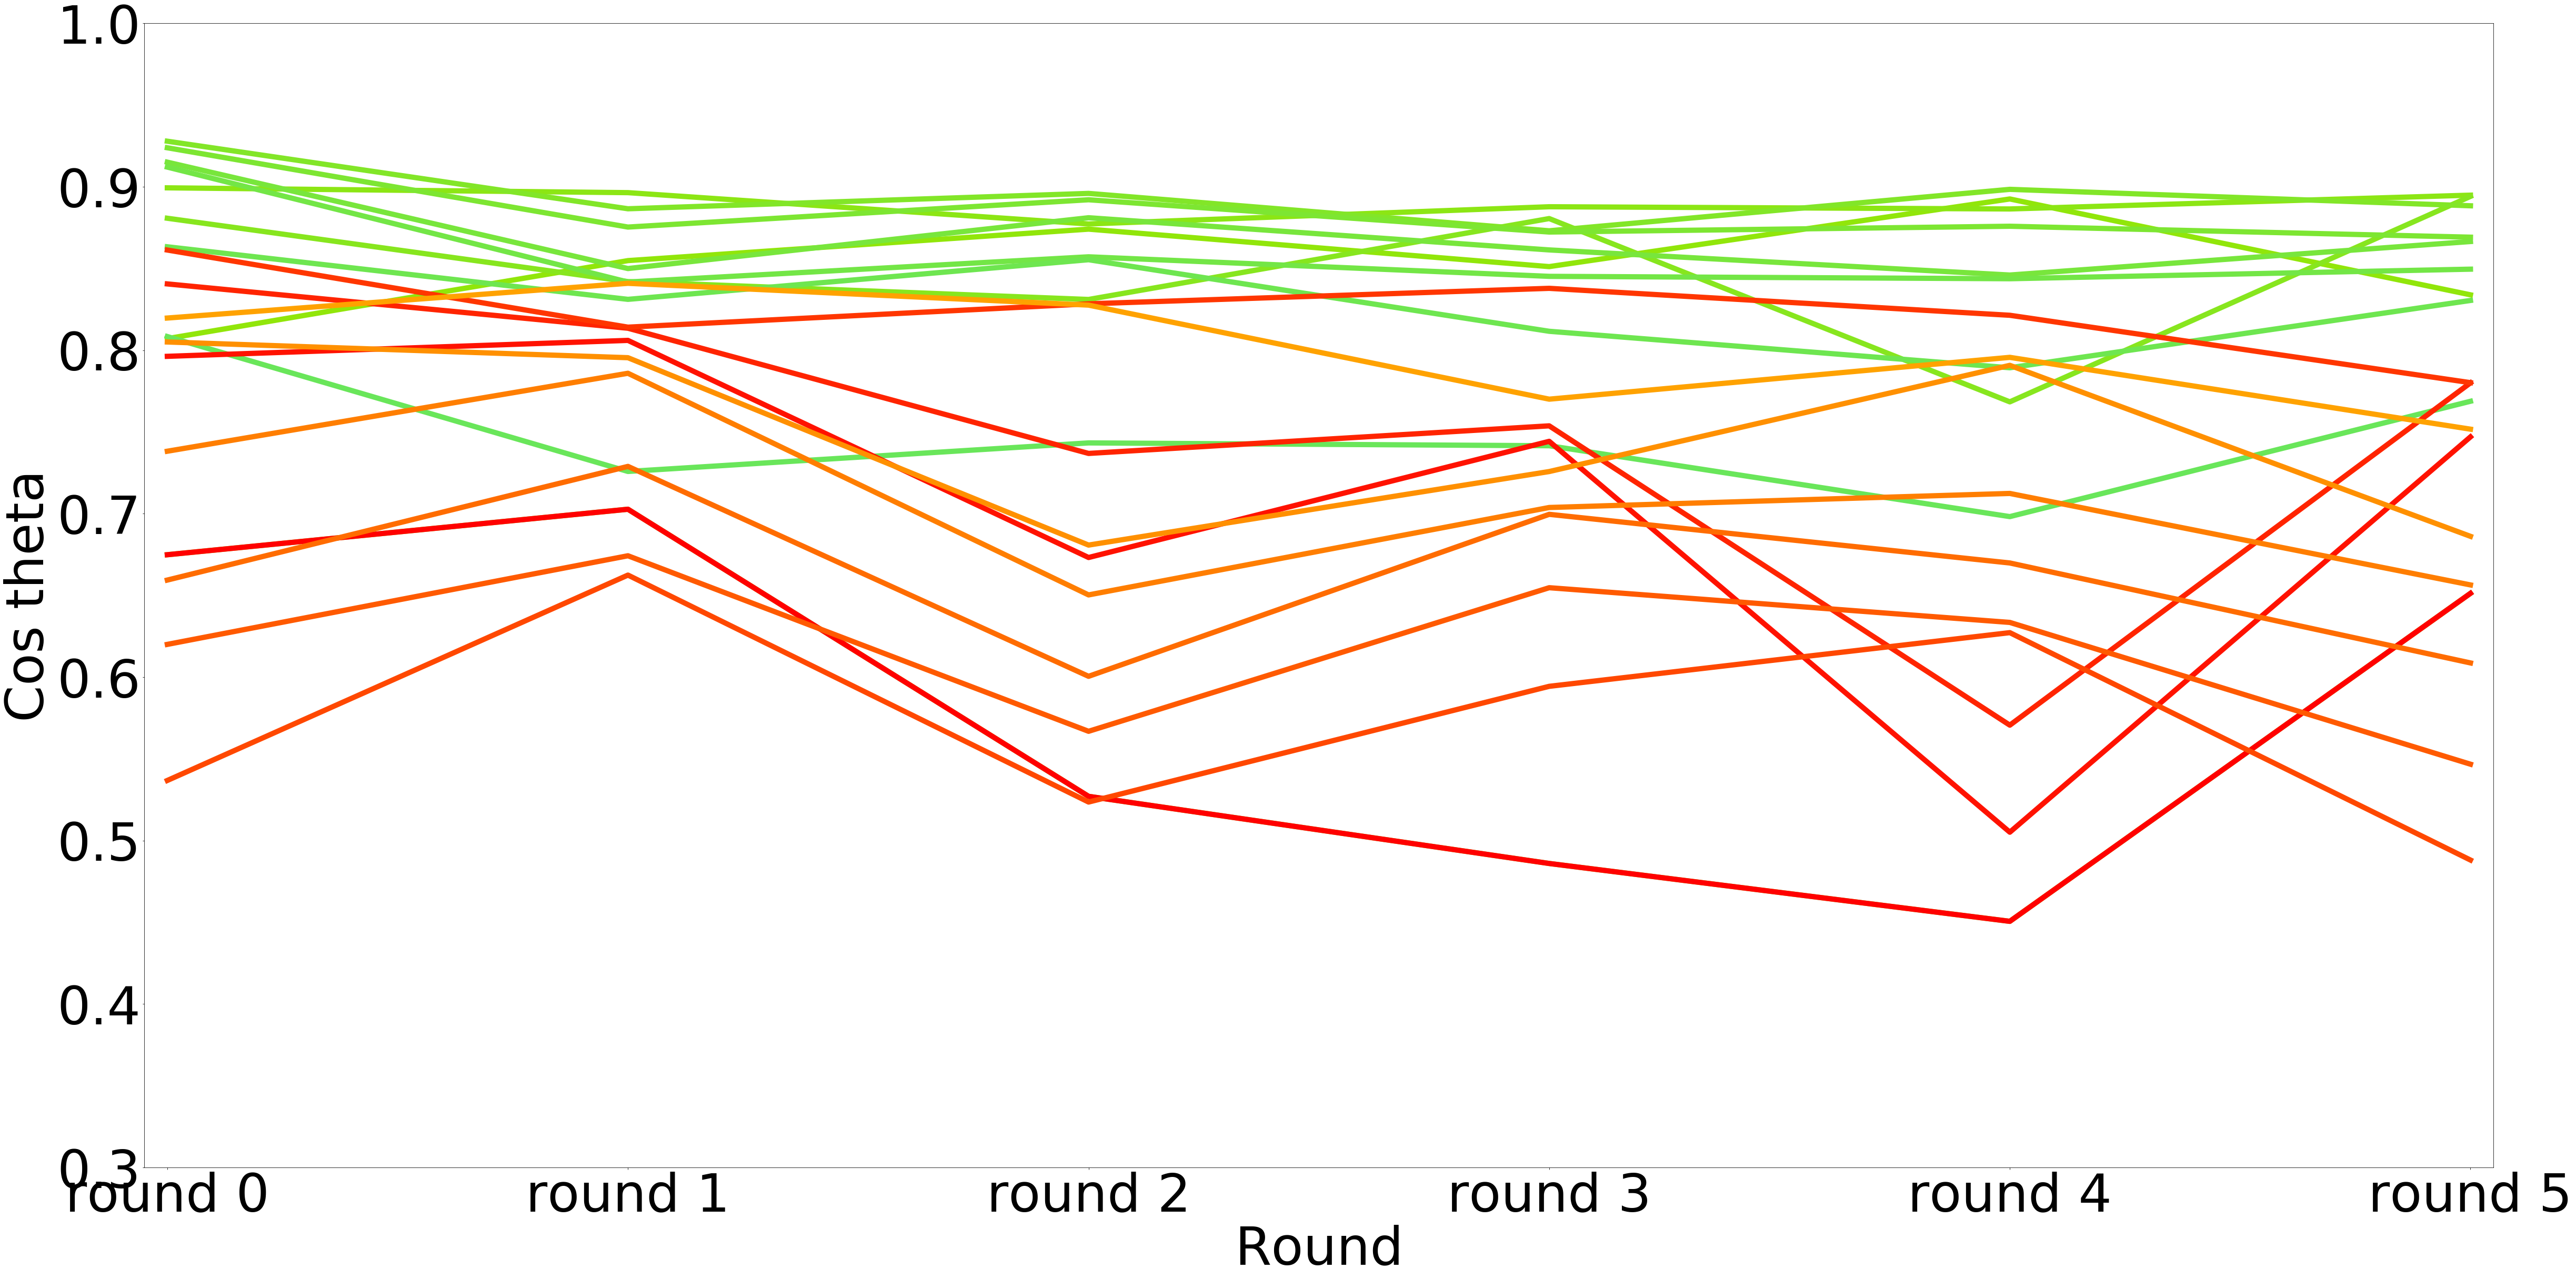

In [18]:
figcos, plotcos = plt.subplots(figsize=(80,40), sharex=True, sharey=True)

plt.xlim(-0.05, 5.05)
plt.ylim(0.3, 1)

plotcos.set_xlabel('Round')
plotcos.set_ylabel('Cos theta')

font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 100}

plt.rc('font', **font)

color = 0
for i in range(len(MABCID[:10])):
    asx, asy = ['round 0', 'round 1', 'round 2', 'round 3', 'round 4', 'round 5'], [CosAMABC[-i], CosBMABC[-i], CosCMABC[-i], CosDMABC[-i], CosEMABC[-i], CosFMABC[-i]]
    
    colors = []
    for i in range(1):
        colors.append("#%02x%02x%02x" % (int(max(min(150-color*0.5, 255), 0)), int(max(min(230, 255), 0)), int(color)))
    
    plotcos.plot(asx, asy, linewidth=10, color=colors[0])
    color += 10

color = 0
for i in range(len(MABCID[:10])):
    asx, asy = ['round 0', 'round 1', 'round 2', 'round 3', 'round 4', 'round 5'], [CosAMABC[i], CosBMABC[i], CosCMABC[i], CosDMABC[i], CosEMABC[i], CosFMABC[i]]
    
    colors = []
    for i in range(1):
        colors.append("#%02x%02x%02x" % (int(max(min(255, 255), 0)), int(max(min(color*1.8, 255), 0)), 0))
    
    plotcos.plot(asx, asy, linewidth=10, color=colors[0])
    plotcos.scatter(asx, asy, color=colors[0])
    color += 10

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from random import shuffle

meancos = [np.mean(rr_data.loc[rr_data['ID'] == ID]['costheta'].values) for ID in IDlist]
meanjerk = [np.mean(rr_data.loc[rr_data['ID'] == ID]['jerk'].values) for ID in IDlist]

x = np.column_stack((meancos, meanjerk))
y = [list(rr_data.loc[rr_data['ID'] == ID]['mabc_binary_score'].values)[0] for ID in IDlist]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0) 

sc = StandardScaler()  
x_train = sc.fit_transform(x_train)  
x_test = sc.transform(x_test)  

regressor = RandomForestRegressor(n_estimators=80, random_state=0)  
regressor.fit(x_train, y_train)  
y_pred = regressor.predict(x_test)

print(confusion_matrix(y_test,y_pred.round()))  
print(classification_report(y_test,y_pred.round()))  
print(accuracy_score(y_test, y_pred.round()))  

[[5 3]
 [5 7]]
              precision    recall  f1-score   support

           0       0.50      0.62      0.56         8
           1       0.70      0.58      0.64        12

   micro avg       0.60      0.60      0.60        20
   macro avg       0.60      0.60      0.60        20
weighted avg       0.62      0.60      0.60        20

0.6


In [40]:
print(y)

[0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0]
